In [1]:
import yfinance as yf

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import date
import math
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler

In [3]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [3]:
data = yf.download('^NSEBANK', start = '2000-01-02', end = date.today())
data = data[['Adj Close']]
data.columns = ['Price']
data.head()

[*********************100%***********************]  1 of 1 completed


,Price
Date,
2007-09-17,6897.020020
2007-09-18,7059.567871
2007-09-19,7401.764160
2007-09-20,7390.063965
2007-09-21,7464.413086


In [4]:
print('There are {} number of days in the dataset.'.format(data.shape[0]))

There are 3896 number of days in the dataset.


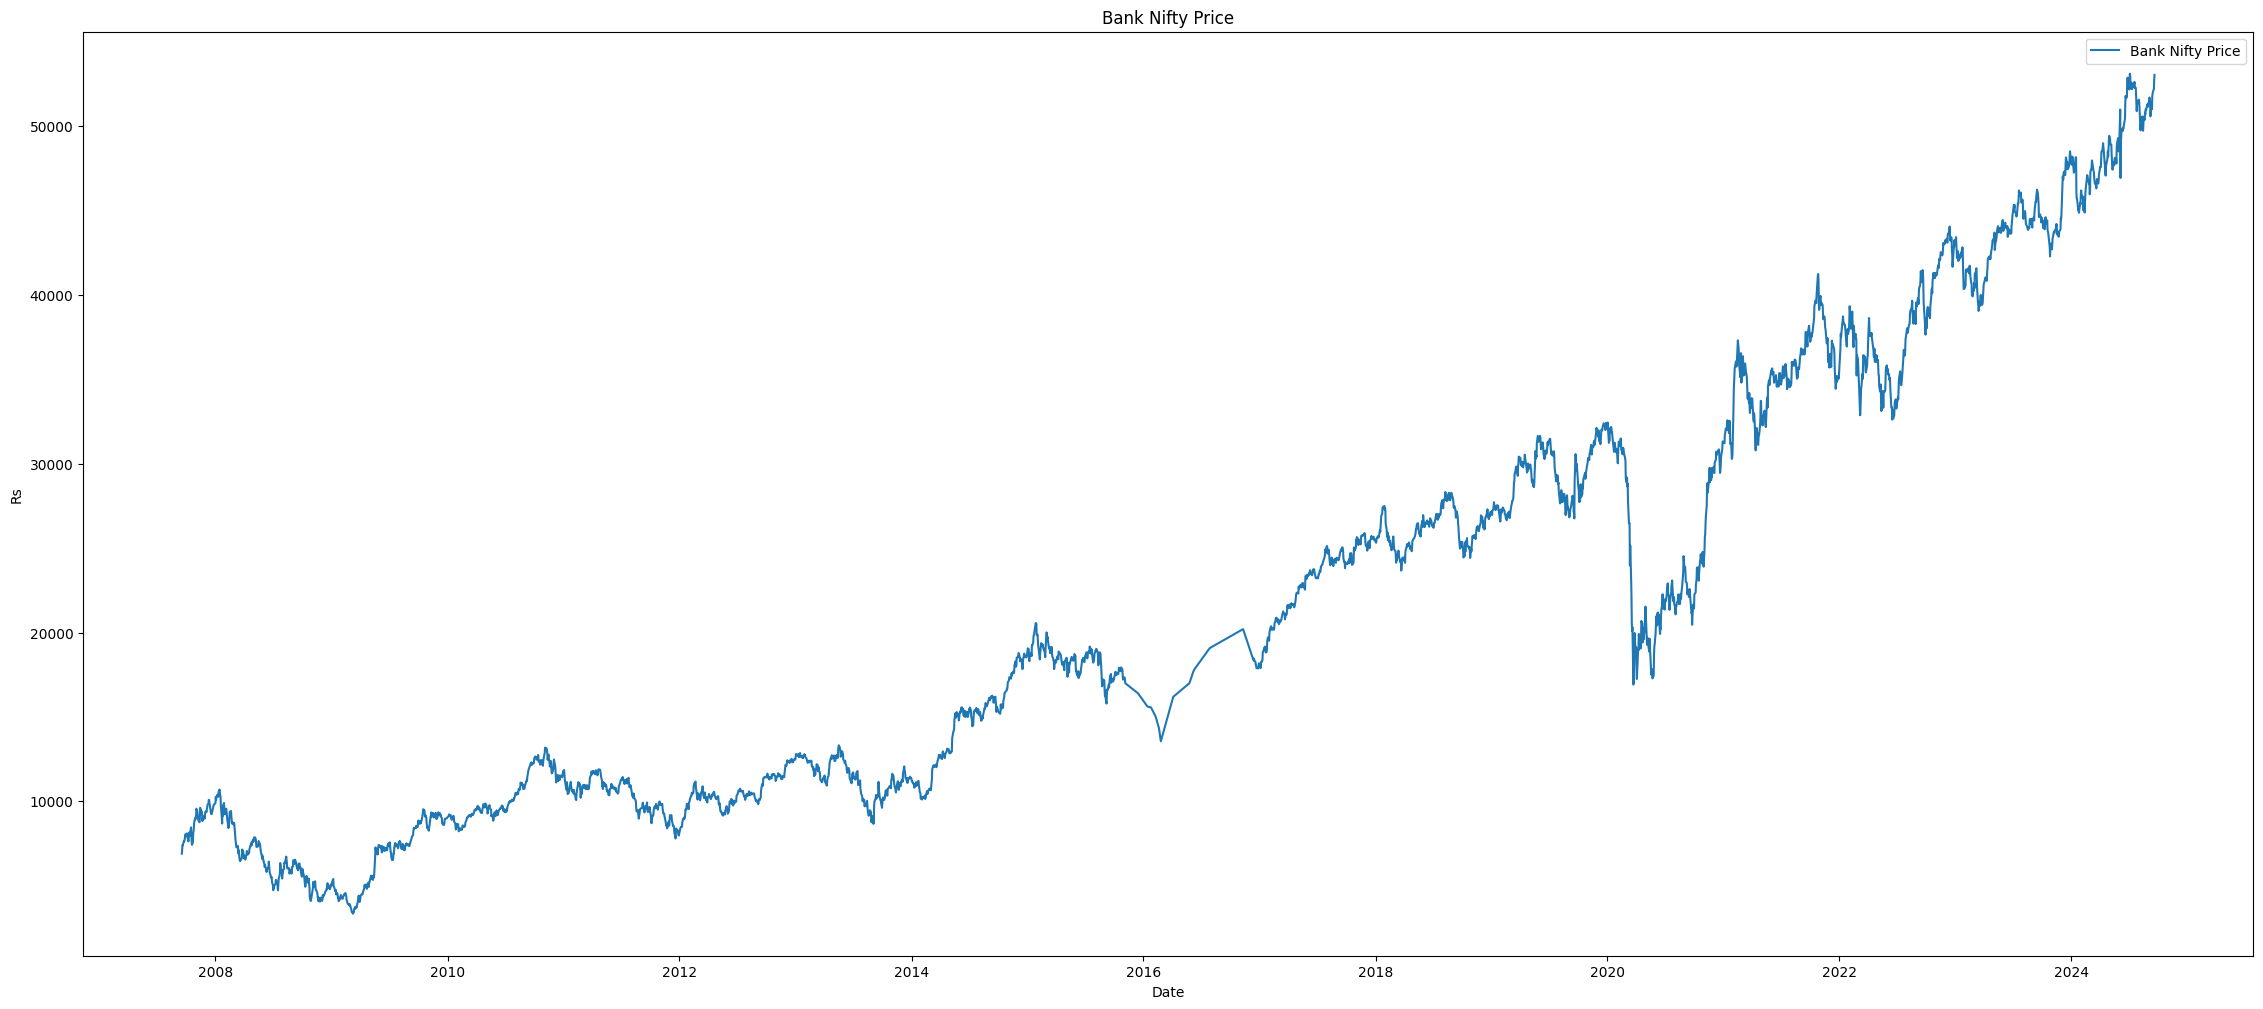

In [5]:
plt.figure(figsize=(28, 12))#, dpi=100)
plt.plot(data.index, data['Price'], label='Bank Nifty Price')
plt.xlabel('Date')
plt.ylabel('Rs')
plt.title('Bank Nifty Price')
plt.legend()
plt.show()

In [6]:
def get_technical_indicators(dataset):
    #  7 and 21 days Moving Average
    dataset['ma7'] = dataset['Price'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Price'].rolling(window=21).mean()

    # MACD
    dataset['26ema'] = dataset['Price'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Price'].ewm(span=12).mean()
    dataset['MACD'] = dataset['12ema']-dataset['26ema']

    # Bollinger Bands
    dataset['20sd'] = dataset['Price'].rolling(window = 21).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)

    # Exponential moving average
    dataset['ema'] = dataset['Price'].ewm(com=0.5).mean()

    # Momentum
    dataset['momentum'] = dataset['Price']-1
    dataset['log_momentum'] = np.log(dataset['momentum'])
    return dataset

In [7]:
df = get_technical_indicators(data)

C:\Users\HP\AppData\Local\Temp\ipykernel_3576\989603969.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['ma7'] = dataset['Price'].rolling(window=7).mean()
C:\Users\HP\AppData\Local\Temp\ipykernel_3576\989603969.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['ma21'] = dataset['Price'].rolling(window=21).mean()
C:\Users\HP\AppData\Local\Temp\ipykernel_3576\989603969.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [8]:
df = df.dropna()
df.head()

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
Date,,,,,,,,,,,,
2007-10-16,8452.101562,8054.791922,7784.471354,7923.731019,8042.612357,118.881339,386.856369,8558.184092,7010.758617,8363.607803,8451.101562,9.042052
2007-10-17,8099.805664,8122.434012,7841.746861,7939.713390,8051.640133,111.926742,334.374992,8510.496844,7172.996878,8187.739710,8098.805664,8.999472
2007-10-18,7608.661621,8081.420201,7867.894182,7910.157159,7981.996045,71.838886,288.470113,8444.834409,7290.953956,7801.687651,7607.661621,8.936911
2007-10-19,7423.713379,7994.728306,7868.939383,7867.378049,7894.519035,27.140986,286.731283,8442.401949,7295.476817,7549.704803,7422.713379,8.912300
2007-10-22,7567.912109,7910.329311,7877.408343,7841.402490,7843.488268,2.085778,274.234037,8425.876416,7328.940269,7561.843007,7566.912109,8.931540


In [9]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days

    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)

    plt.figure(figsize=(30,20))
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Price'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot

    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
#     plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
#     plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

<Figure size 1600x1000 with 0 Axes>

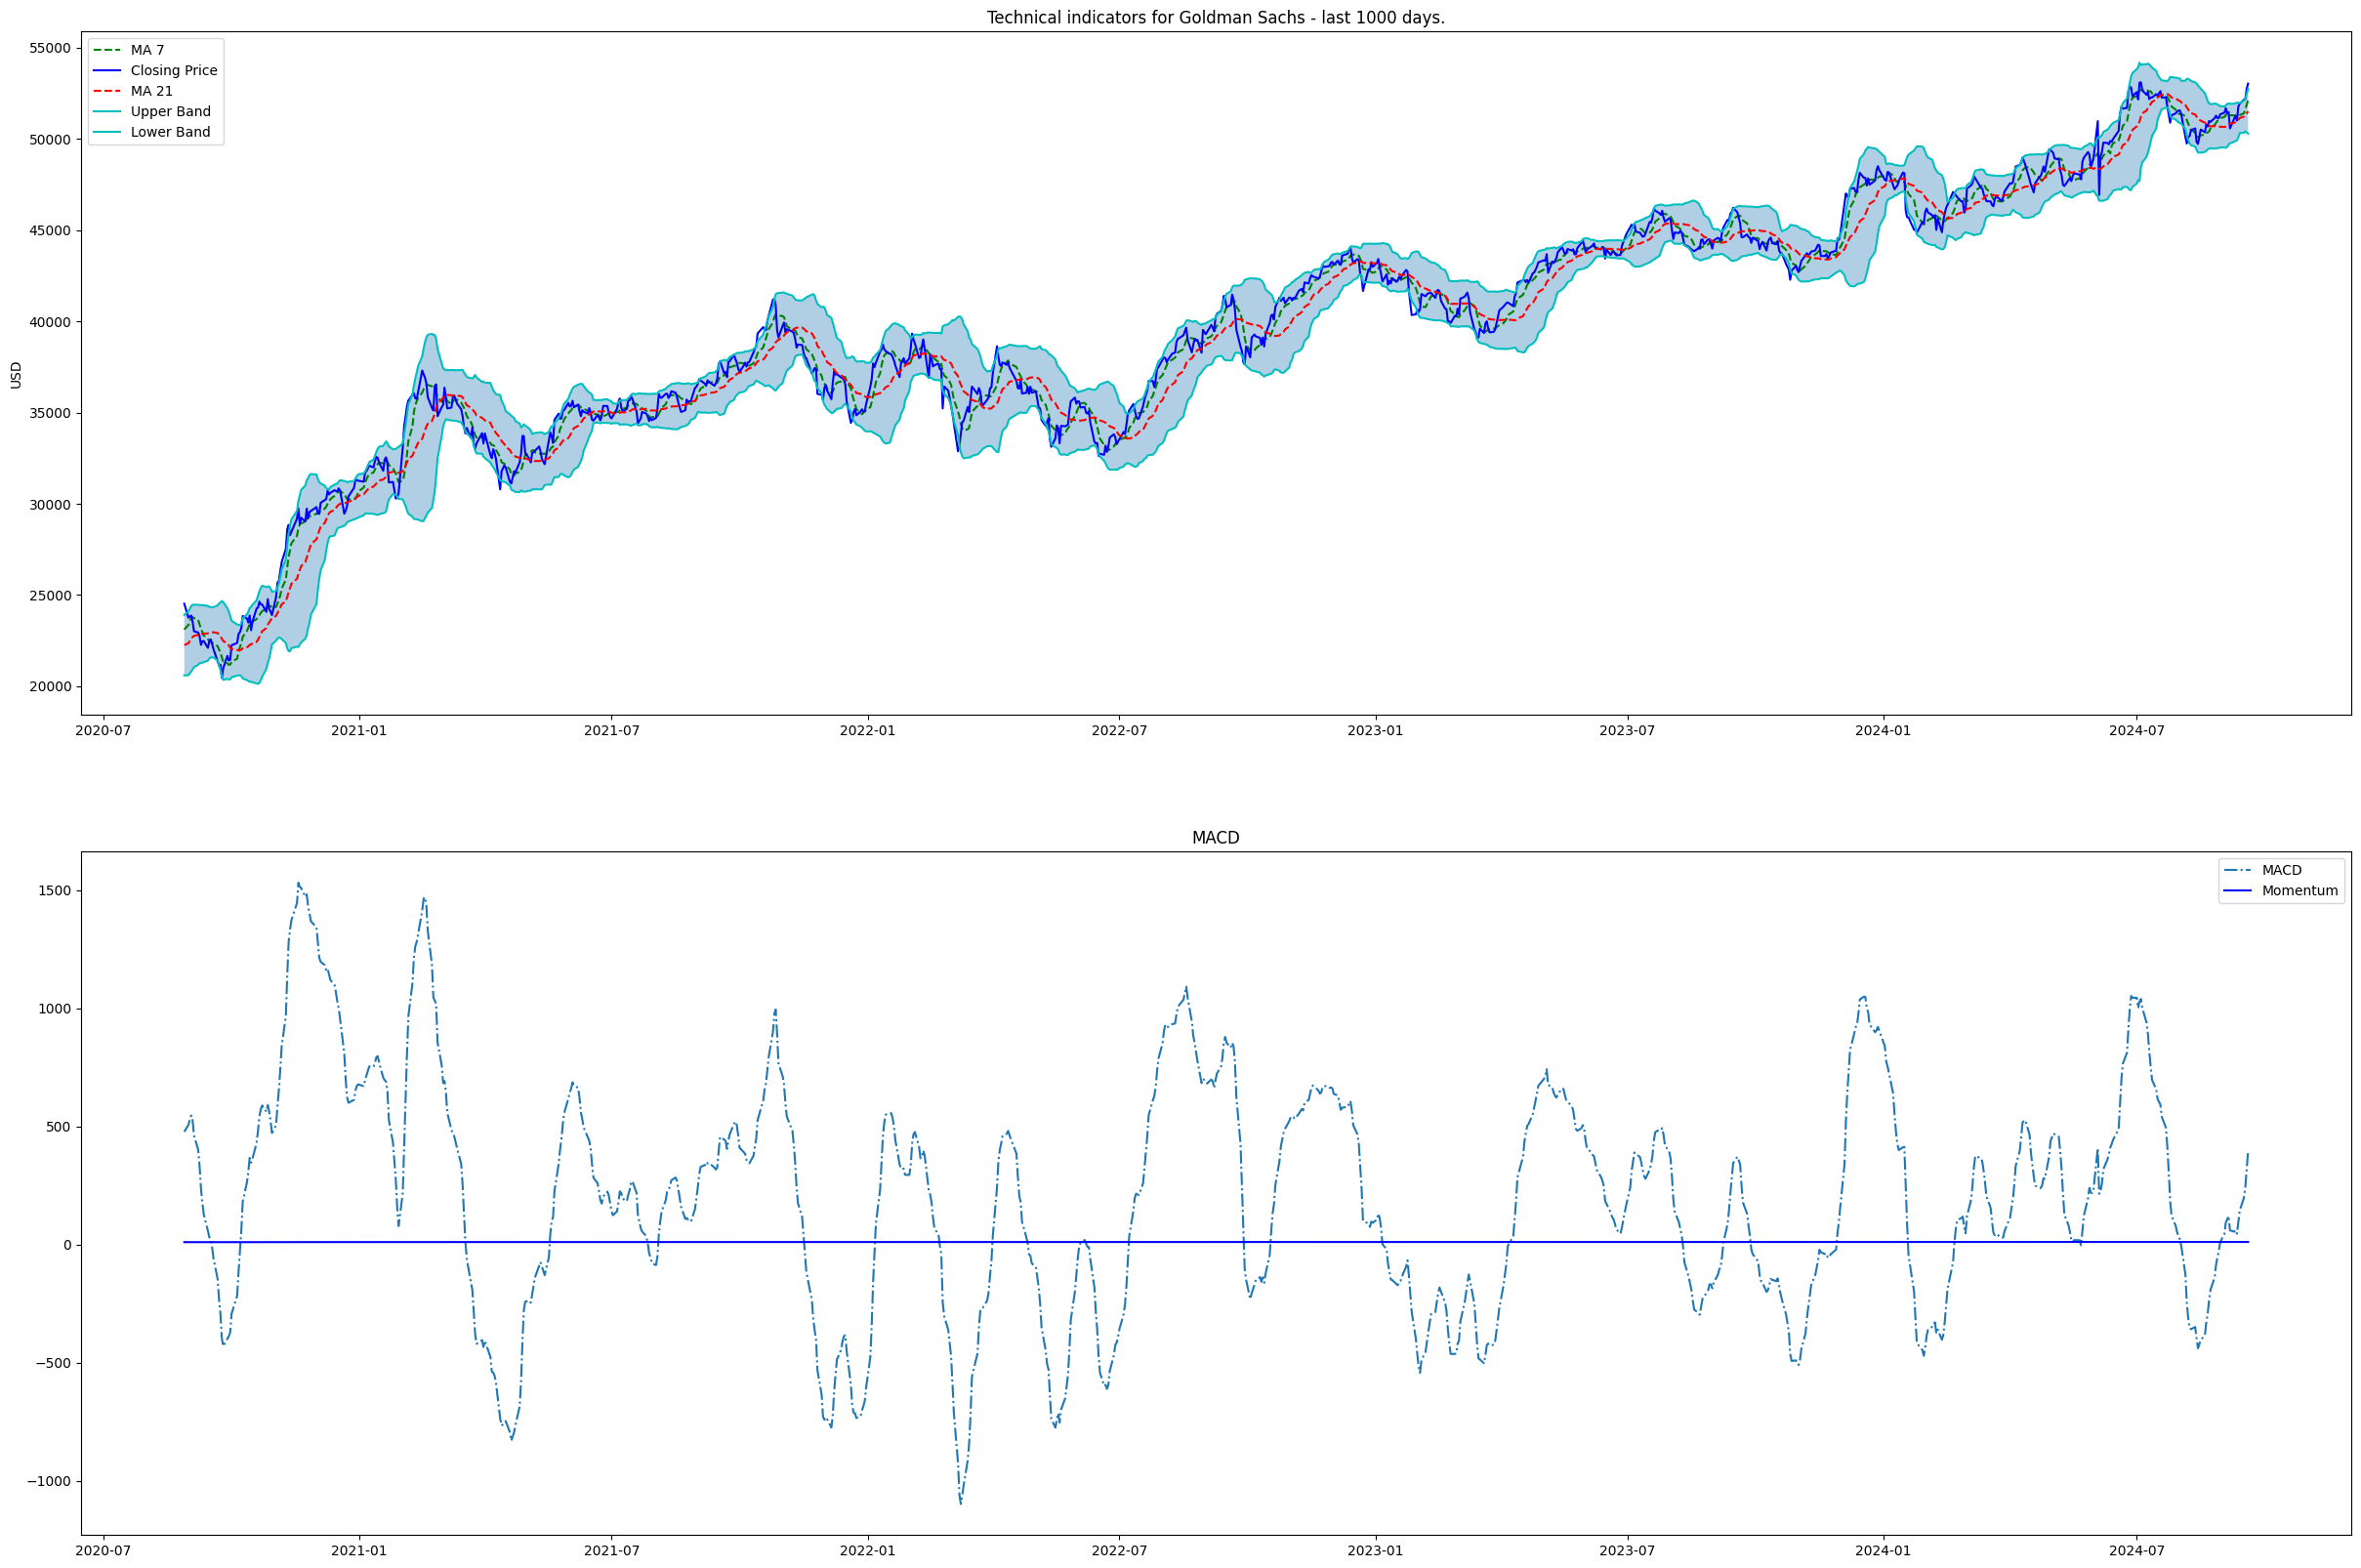

In [10]:
plot_technical_indicators(df, 1000)

Text(0.5, 1.0, 'Params')

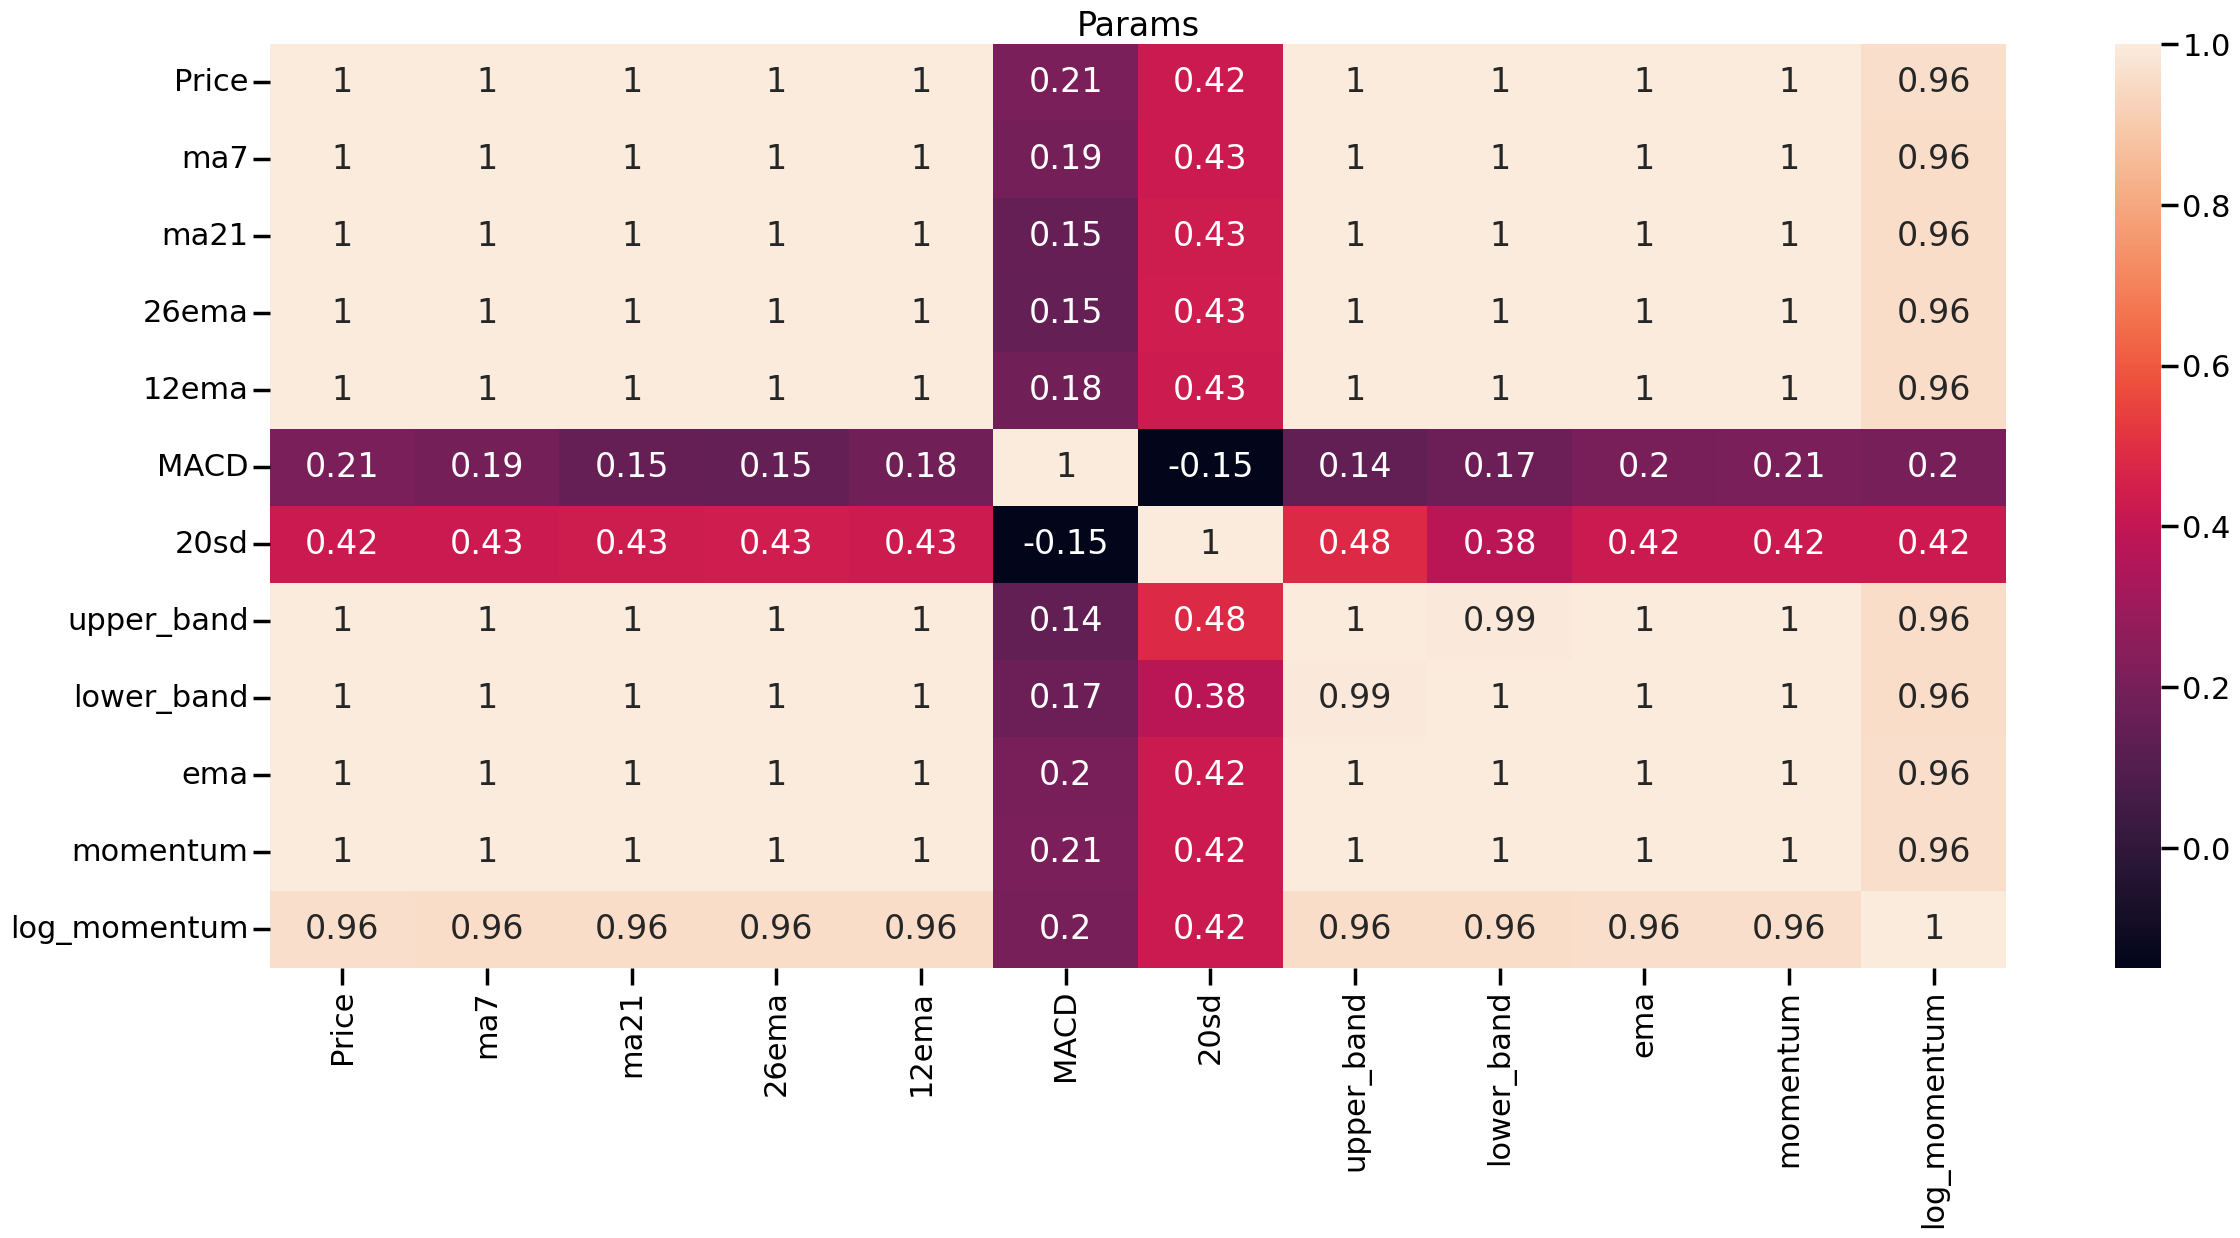

In [11]:
plt.figure(figsize = (28,12))
sns.set_context('poster',font_scale=1)
sns.heatmap(df.corr(), annot = True).set_title('Params')


In [12]:
print('Total dataset has {} samples, and {} features.'.format(df.shape[0], \
                                                              df.shape[1]))

Total dataset has 3876 samples, and 12 features.


In [13]:
df.columns

Index(['Price', 'ma7', 'ma21', '26ema', '12ema', 'MACD', '20sd', 'upper_band',
       'lower_band', 'ema', 'momentum', 'log_momentum'],
      dtype='object')

In [14]:
df

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
Date,,,,,,,,,,,,
2007-10-16,8452.101562,8054.791922,7784.471354,7923.731019,8042.612357,118.881339,386.856369,8558.184092,7010.758617,8363.607803,8451.101562,9.042052
2007-10-17,8099.805664,8122.434012,7841.746861,7939.713390,8051.640133,111.926742,334.374992,8510.496844,7172.996878,8187.739710,8098.805664,8.999472
2007-10-18,7608.661621,8081.420201,7867.894182,7910.157159,7981.996045,71.838886,288.470113,8444.834409,7290.953956,7801.687651,7607.661621,8.936911
2007-10-19,7423.713379,7994.728306,7868.939383,7867.378049,7894.519035,27.140986,286.731283,8442.401949,7295.476817,7549.704803,7422.713379,8.912300
2007-10-22,7567.912109,7910.329311,7877.408343,7841.402490,7843.488268,2.085778,274.234037,8425.876416,7328.940269,7561.843007,7566.912109,8.931540
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-13,51938.050781,51308.636161,51145.566964,51194.122903,51337.598015,143.475112,411.841478,51969.249920,50321.884009,51804.928523,51937.050781,10.857788
2024-09-16,52153.148438,51405.792969,51223.483631,51265.161832,51463.067311,197.905479,440.725153,52104.933938,50342.033324,52037.075133,52152.148438,10.861921
2024-09-17,52188.648438,51636.049665,51310.164435,51333.568247,51574.695176,241.126930,443.129816,52196.424066,50423.904803,52138.124003,52187.648438,10.862601


In [15]:
data_training = df[df.index < '2020-01-31'].copy()
data_training

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
Date,,,,,,,,,,,,
2007-10-16,8452.101562,8054.791922,7784.471354,7923.731019,8042.612357,118.881339,386.856369,8558.184092,7010.758617,8363.607803,8451.101562,9.042052
2007-10-17,8099.805664,8122.434012,7841.746861,7939.713390,8051.640133,111.926742,334.374992,8510.496844,7172.996878,8187.739710,8098.805664,8.999472
2007-10-18,7608.661621,8081.420201,7867.894182,7910.157159,7981.996045,71.838886,288.470113,8444.834409,7290.953956,7801.687651,7607.661621,8.936911
2007-10-19,7423.713379,7994.728306,7868.939383,7867.378049,7894.519035,27.140986,286.731283,8442.401949,7295.476817,7549.704803,7422.713379,8.912300
2007-10-22,7567.912109,7910.329311,7877.408343,7841.402490,7843.488268,2.085778,274.234037,8425.876416,7328.940269,7561.843007,7566.912109,8.931540
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-24,31241.386719,31202.494420,31720.293341,31565.852787,31388.655335,-177.197452,533.871579,32788.036499,30652.550182,31141.777205,31240.386719,10.349467
2020-01-27,30837.041016,31057.281808,31665.041574,31511.866730,31303.791594,-208.075136,563.012244,32791.066062,30539.017085,30938.619745,30836.041016,10.336439
2020-01-28,30761.042969,30938.818917,31586.425874,31456.250155,31220.291805,-235.958349,568.734305,32723.894484,30448.957265,30820.235228,30760.042969,10.333972


In [16]:
data_testing = df[df.index >= '2019-01-31'].copy()
data_testing

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
Date,,,,,,,,,,,,
2019-01-31,27295.132812,26996.808036,27275.187872,27110.569379,27112.501377,1.931998,302.590552,27880.368977,26670.006767,27119.841293,27294.132812,10.214427
2019-02-01,27085.634766,26973.265346,27281.192522,27108.722371,27108.368052,-0.354318,297.216979,27875.626480,26686.758564,27097.036941,27084.634766,10.206722
2019-02-04,27186.283203,26961.865234,27280.792504,27114.467617,27120.354998,5.887381,297.344857,27875.482217,26686.102790,27156.534449,27185.283203,10.210431
2019-02-05,27271.382812,26984.207589,27279.228144,27126.090965,27143.590047,17.499082,297.301775,27873.831693,26684.624594,27233.100025,27270.382812,10.213557
2019-02-06,27402.031250,27091.249163,27274.125837,27146.530986,27183.350232,36.819246,294.059781,27862.245398,26686.006276,27345.720842,27401.031250,10.218336
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-13,51938.050781,51308.636161,51145.566964,51194.122903,51337.598015,143.475112,411.841478,51969.249920,50321.884009,51804.928523,51937.050781,10.857788
2024-09-16,52153.148438,51405.792969,51223.483631,51265.161832,51463.067311,197.905479,440.725153,52104.933938,50342.033324,52037.075133,52152.148438,10.861921
2024-09-17,52188.648438,51636.049665,51310.164435,51333.568247,51574.695176,241.126930,443.129816,52196.424066,50423.904803,52138.124003,52187.648438,10.862601


In [17]:
scalar = MinMaxScaler()

data_training_scaled = scalar.fit_transform(data_training)
print(data_training_scaled.shape)
data_training_scaled

(2734, 12)


array([[0.17566223, 0.15805616, 0.1431213 , ..., 0.17181035, 0.17566223,
        0.40842935],
       [0.16355743, 0.16040638, 0.14514206, ..., 0.16574291, 0.16355743,
        0.38970372],
       [0.14668184, 0.15898136, 0.14606458, ..., 0.15242413, 0.14668184,
        0.36219117],
       ...,
       [0.94219212, 0.95315806, 0.98288722, ..., 0.9465632 , 0.94219212,
        0.97658123],
       [0.94616403, 0.95214724, 0.98040428, ..., 0.94786053, 0.94616403,
        0.97823082],
       [0.93827517, 0.95065745, 0.97786027, ..., 0.94301227, 0.93827517,
        0.97494838]])

In [18]:
X_train = []
y_train = []

In [19]:
for i in range(60, data_training.shape[0]):
    X_train.append(data_training_scaled[i-60: i])
    y_train.append(data_training_scaled[i, 0])

In [20]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((2674, 60, 12), (2674,))

In [22]:
regressor = Sequential()

regressor.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 12)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units = 120, activation = 'relu'))
regressor.add(Dropout(0.5))

regressor.add(Dense(units = 1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
regressor.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          12,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 60, 60)              │          26,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 60, 60)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 60, 80)              │          45,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60, 80)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 120)                 │          96,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 180,961 (706.88 KB)

 Trainable params: 180,961 (706.88 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [25]:
regressor.fit(X_train, y_train, epochs=50, batch_size = 64)

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 201ms/step - loss: 0.2106
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0181
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0115
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0080
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0067
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0055
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0060
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0061
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0049
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0051
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0045
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0050
Epoch 13/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0045
Epoch 14/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0045
Epoch 15/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0046
Ep

In [21]:
past_60 = data_training.tail(60)

dt = pd.concat([past_60, data_testing], ignore_index=True)
dt

,Price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
0,30219.498047,30029.115234,29062.795387,29252.461888,29730.232535,477.770648,862.416949,30787.629284,27337.961490,30244.990792,30218.498047,10.316210
1,30609.244141,30202.491908,29167.341797,29352.964277,29865.465090,512.500813,911.482311,30990.306419,27344.377175,30487.826358,30608.244141,10.329025
2,30632.794922,30311.076451,29305.497396,29447.766547,29983.515833,535.749286,902.805722,31111.108839,27499.885953,30584.472067,30631.794922,10.329794
3,30749.042969,30419.917969,29447.488560,29544.157393,30101.289239,557.131846,883.043736,31213.576032,27681.401089,30694.186002,30748.042969,10.333582
4,31115.189453,30569.816406,29558.425409,29660.530138,30257.273887,596.743749,940.209982,31438.845374,27678.005445,30974.854969,31114.189453,10.345419
...,...,...,...,...,...,...,...,...,...,...,...,...
1438,51938.050781,51308.636161,51145.566964,51194.122903,51337.598015,143.475112,411.841478,51969.249920,50321.884009,51804.928523,51937.050781,10.857788
1439,52153.148438,51405.792969,51223.483631,51265.161832,51463.067311,197.905479,440.725153,52104.933938,50342.033324,52037.075133,52152.148438,10.861921
1440,52188.648438,51636.049665,51310.164435,51333.568247,51574.695176,241.126930,443.129816,52196.424066,50423.904803,52138.124003,52187.648438,10.862601
1441,52750.398438,51869.277902,51402.890625,51438.518631,51755.572601,317.053970,527.443284,52457.777193,50348.004057,52546.306959,52749.398438,10.873308


In [22]:
inputs = scalar.fit_transform(dt)
print(inputs.shape)
inputs

(1443, 12)


array([[0.36759947, 0.35174294, 0.30387575, ..., 0.3602089 , 0.36759947,
        0.5071656 ],
       [0.37837003, 0.35669865, 0.30698752, ..., 0.36703345, 0.37837003,
        0.51836822],
       [0.37902085, 0.35980237, 0.31109966, ..., 0.36974954, 0.37902085,
        0.51904057],
       ...,
       [0.97471275, 0.96934421, 0.96605736, ..., 0.97548391, 0.97471275,
        0.98480524],
       [0.9902366 , 0.97601068, 0.96881731, ..., 0.9869553 , 0.9902366 ,
        0.99416457],
       [0.9981734 , 0.98321903, 0.972151  , ..., 0.99616005, 0.9981734 ,
        0.99891123]])

In [23]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((1383, 60, 12), (1383,))

In [29]:
y_pred = regressor.predict(X_test)

44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step


In [30]:
y_pred

array([[0.3773796 ],
       [0.37612298],
       [0.37444806],
       ...,
       [0.7928127 ],
       [0.79335886],
       [0.7939954 ]], dtype=float32)

In [31]:
scale = 1/scalar.scale_[0]

In [32]:
y_pred = y_pred*scale
y_test = y_test*scale

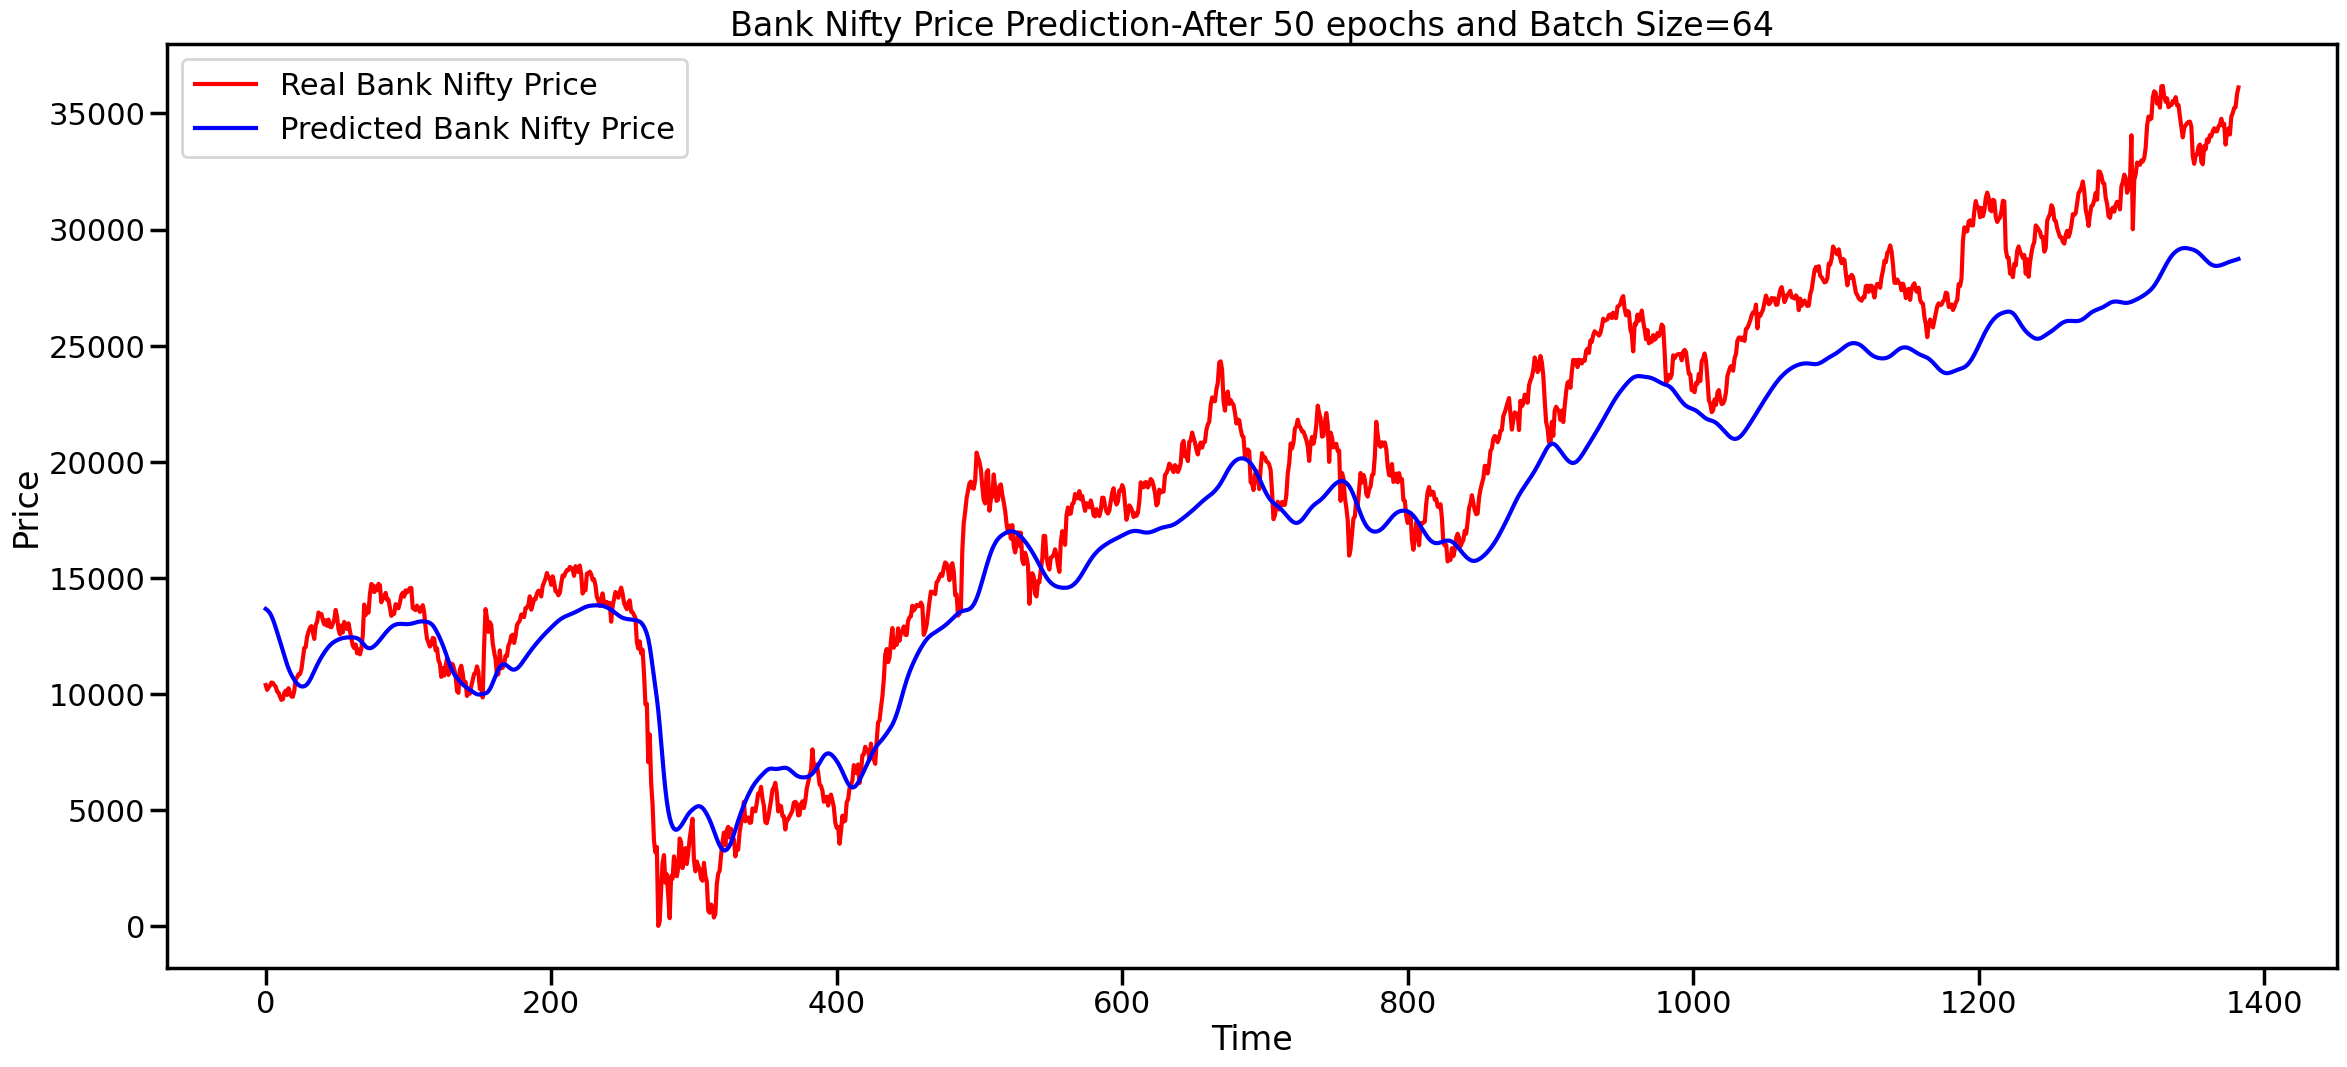

In [33]:
# Visualising the results
plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Real Bank Nifty Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Bank Nifty Price')
plt.title('Bank Nifty Price Prediction-After 50 epochs and Batch Size=64')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

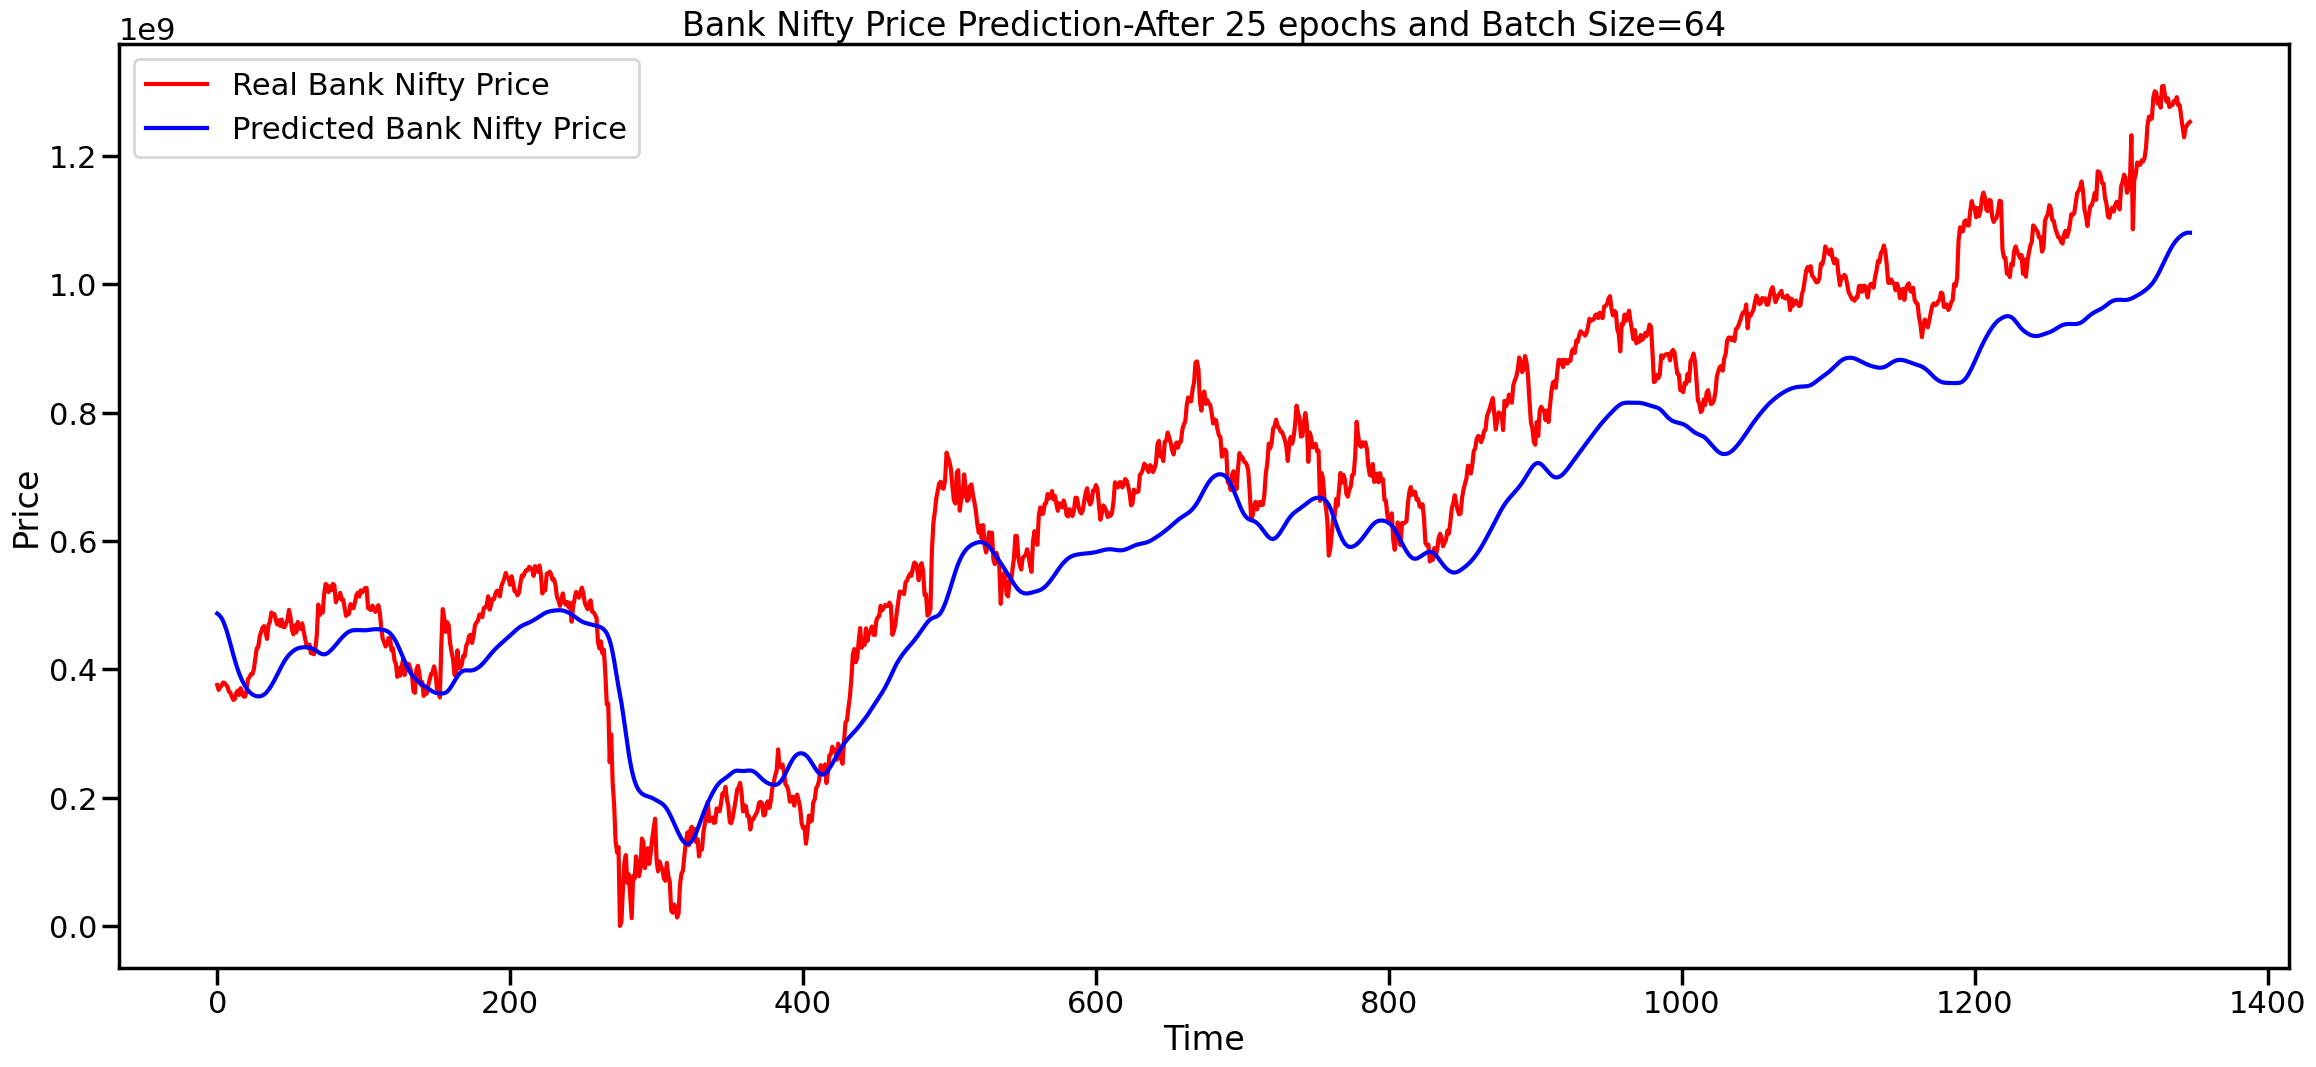

In [ ]:

plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Real Bank Nifty Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Bank Nifty Price')
plt.title('Bank Nifty Price Prediction-After 25 epochs and Batch Size=64')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

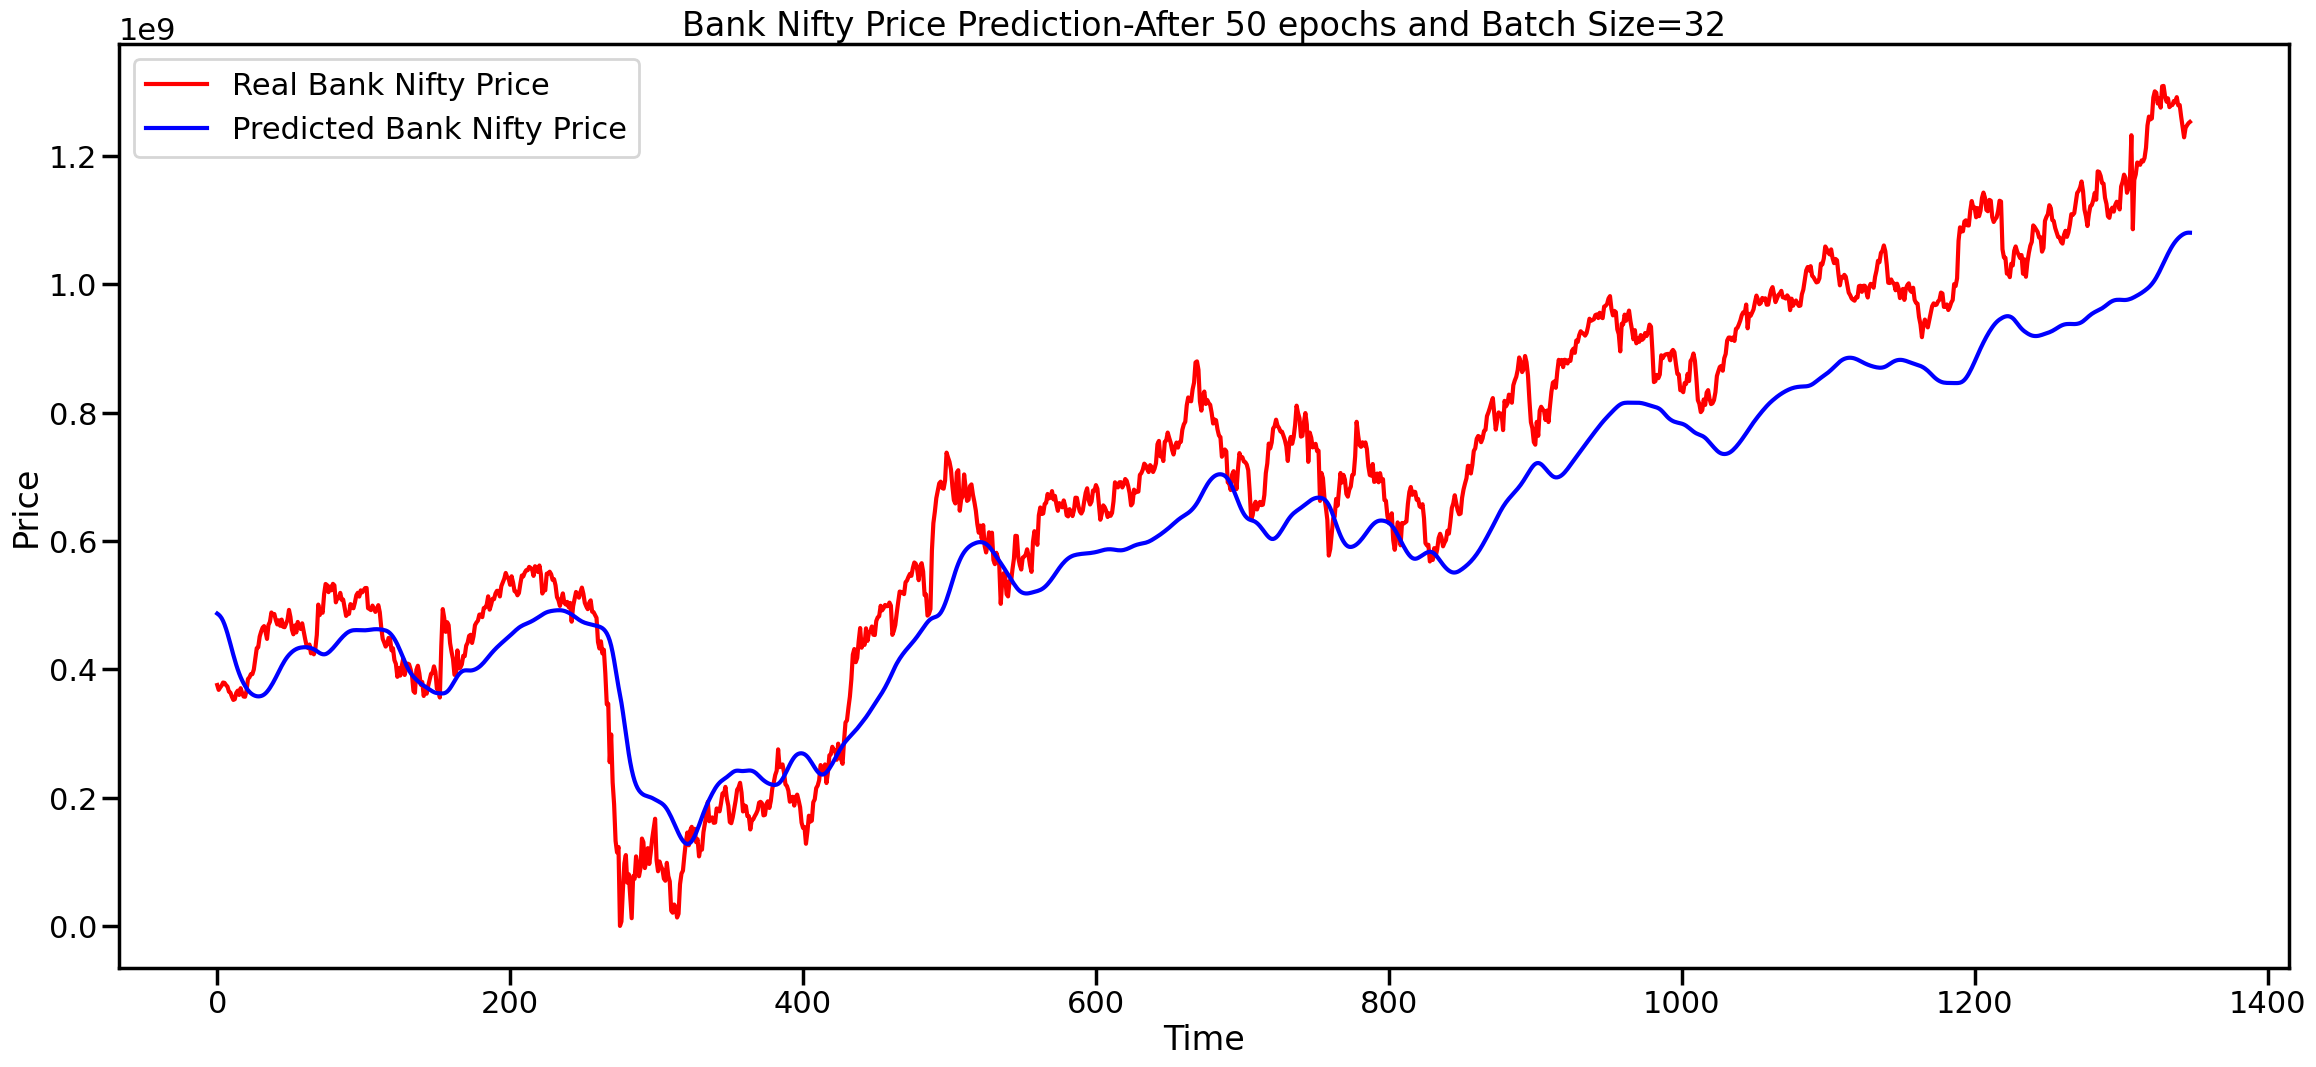

In [ ]:

plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Real Bank Nifty Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Bank Nifty Price')
plt.title('Bank Nifty Price Prediction-After 50 epochs and Batch Size=32')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# VaR Backtesting

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import chi2
import plotly.graph_objects as go

In [ ]:
# Fetching historical data
data = yf.download('^NSEBANK', start='2015-05-01', end='2024-05-01')
prices = data['Close']
# Computing daily returns
returns = prices.pct_change().dropna()
returns

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2015-05-05,-0.001613
2015-05-06,-0.036375
2015-05-07,-0.023745
2015-05-11,0.047353
2015-05-12,-0.031380
2015-05-13,0.026593
2015-05-14,0.001036
2015-05-18,0.016932
2015-05-19,-0.002310


In [ ]:
 # Setting confidence level and historical window
confidence_level = 0.95
var_level = np.percentile(returns, 100 * (1 - confidence_level))

exceedances = returns < var_level
# exceedances

In [ ]:
def kupiec_pof_test(returns, var_level, confidence_level):
  n = len(returns)
  n_fail = exceedances.sum()
  p = 1 - confidence_level
  LR_pof = -2 * np.log(((1 - p) ** (n - n_fail)) * (p ** n_fail)) + 2 * np.log(((1 - n_fail/n) ** (n - n_fail)) * (n_fail/n) ** n_fail)
  p_value = 1 - chi2.cdf(LR_pof, 1)
  return LR_pof, p_value
  LR_pof, p_value_pof = kupiec_pof_test(returns, var_level, confidence_level)
  print("Kupiec POF Test LR statistic:", LR_pof)
  print("P-Value:", p_value_pof)


In [ ]:
def christoffersen_test(exceedances):
  n = len(exceedances)
  n_fail = exceedances.sum()
  clusters = (exceedances[:-1] & exceedances[1:]).sum()
  p_fail = n_fail / n
  p_cluster = clusters / n_fail if n_fail > 0 else 0
  LR_ind = -2 * (np.log((1 - p_cluster) ** (n_fail - clusters)) + np.log(p_cluster ** clusters)) + 2 * (np.log((1 - p_fail) ** (n_fail-clusters)) + np.log(p_fail ** clusters))
  p_value_ind = 1 - chi2.cdf(LR_ind, 1)
  return LR_ind, p_value_ind

LR_ind, p_value_ind = christoffersen_test(exceedances)
print("Christoffersen's Test LR statistic:", LR_ind)
print("P-Value:", p_value_ind)



Christoffersen's Test LR statistic: -585.7585016787741
P-Value: 1.0


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=returns.index, y=returns, mode='lines', name='DailyReturns'))
fig.add_trace(go.Scatter(x=returns[exceedances].index, y=returns[exceedances],mode='markers', name='Exceedances', marker=dict(color='red')))
fig.update_layout(title="VaR Exceedances Visualization", xaxis_title="Date",yaxis_title="Returns", legend_title="Legend")
fig.show()


# PYTORCH

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
# Improved model architecture
class ImprovedNiftyModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(ImprovedNiftyModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.output = nn.Linear(64, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.relu(out)
        out = self.dropout(out)
        out = self.output(out)
        return out


In [26]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch.unsqueeze(1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch.unsqueeze(1))
                val_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}')

    return model

In [27]:
X_train, X_test, y_train, y_test

(array([[[0.17566223, 0.15805616, 0.1431213 , ..., 0.17181035,
          0.17566223, 0.40842935],
         [0.16355743, 0.16040638, 0.14514206, ..., 0.16574291,
          0.16355743, 0.38970372],
         [0.14668184, 0.15898136, 0.14606458, ..., 0.15242413,
          0.14668184, 0.36219117],
         ...,
         [0.24106184, 0.23109866, 0.21583355, ..., 0.24017542,
          0.24106184, 0.49775719],
         [0.23937308, 0.23329748, 0.21669096, ..., 0.23928127,
          0.23937308, 0.49566475],
         [0.23801244, 0.23509228, 0.21736676, ..., 0.23807243,
          0.23801244, 0.49397161]],
 
        [[0.16355743, 0.16040638, 0.14514206, ..., 0.16574291,
          0.16355743, 0.38970372],
         [0.14668184, 0.15898136, 0.14606458, ..., 0.15242413,
          0.14668184, 0.36219117],
         [0.14032706, 0.15596926, 0.14610145, ..., 0.14373073,
          0.14032706, 0.35136783],
         ...,
         [0.23937308, 0.23329748, 0.21669096, ..., 0.23928127,
          0.23937308, 0.

In [28]:
#DataLoaders
train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
test_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_test[:len(y_test)]), torch.FloatTensor(y_test)) # Slice X_test to match the length of y_test
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [33]:

input_size = X_train.shape[2]  # Number of features
hidden_size = 128
num_layers = 2
output_size = 1
model = ImprovedNiftyModel(input_size, hidden_size, num_layers, output_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
   # Train model
trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device)

Epoch [1/50], Train Loss: 0.0329, Val Loss: 0.0023
Epoch [2/50], Train Loss: 0.0034, Val Loss: 0.0016
Epoch [3/50], Train Loss: 0.0031, Val Loss: 0.0019
Epoch [4/50], Train Loss: 0.0029, Val Loss: 0.0021
Epoch [5/50], Train Loss: 0.0026, Val Loss: 0.0012
Epoch [6/50], Train Loss: 0.0026, Val Loss: 0.0017
Epoch [7/50], Train Loss: 0.0026, Val Loss: 0.0012
Epoch [8/50], Train Loss: 0.0030, Val Loss: 0.0016
Epoch [9/50], Train Loss: 0.0026, Val Loss: 0.0016
Epoch [10/50], Train Loss: 0.0024, Val Loss: 0.0013
Epoch [11/50], Train Loss: 0.0023, Val Loss: 0.0012
Epoch [12/50], Train Loss: 0.0025, Val Loss: 0.0012
Epoch [13/50], Train Loss: 0.0023, Val Loss: 0.0011
Epoch [14/50], Train Loss: 0.0023, Val Loss: 0.0010
Epoch [15/50], Train Loss: 0.0021, Val Loss: 0.0014
Epoch [16/50], Train Loss: 0.0024, Val Loss: 0.0011
Epoch [17/50], Train Loss: 0.0022, Val Loss: 0.0017
Epoch [18/50], Train Loss: 0.0021, Val Loss: 0.0010
Epoch [19/50], Train Loss: 0.0022, Val Loss: 0.0014
Epoch [20/50], Train 

Shape of predictions before reshape: (1383, 1)
Shape of y_test: (1383,)


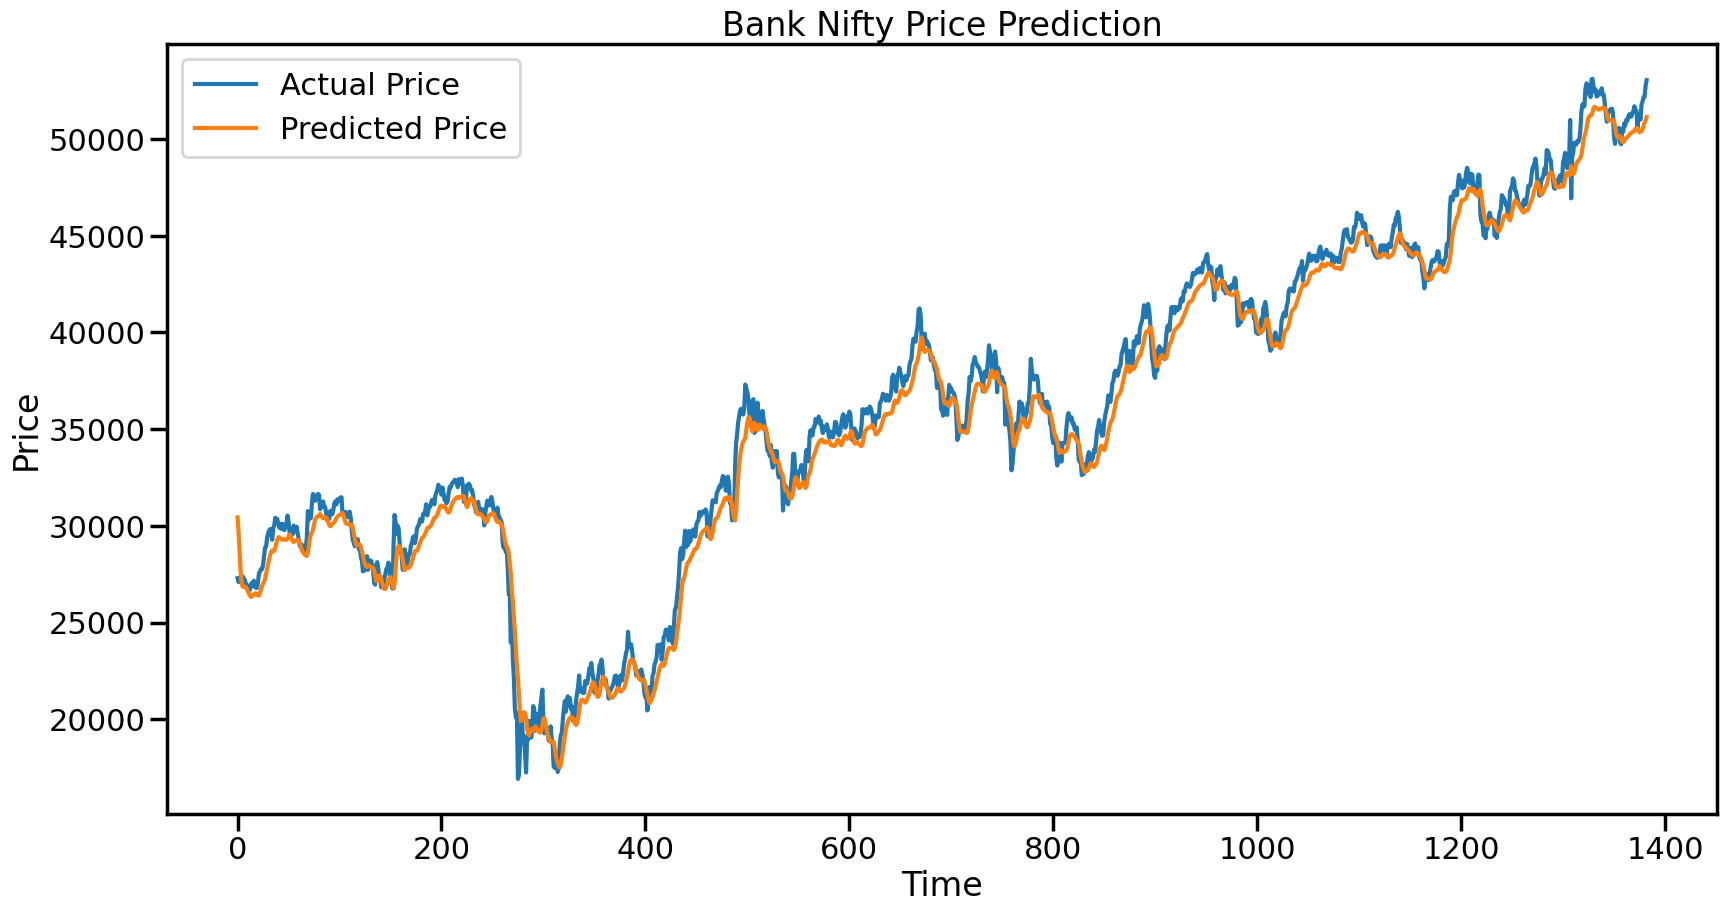

Root Mean Square Error: 1017.02


In [35]:
# predictions
model.eval()
predictions = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_pred = model(X_batch)
        predictions.extend(y_pred.cpu().numpy())

print(f"Shape of predictions before reshape: {np.array(predictions).shape}")
print(f"Shape of y_test: {y_test.shape}")


predictions = np.array(predictions).reshape(-1, 1)

# dummy array with the same number of features as the scaler was fitted on
dummy_array = np.zeros((predictions.shape[0], scalar.n_features_in_))
dummy_array[:, 0] = predictions[:, 0]


predictions = scalar.inverse_transform(dummy_array)[:, 0].reshape(-1, 1)
y_test_actual = scalar.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scalar.n_features_in_ - 1)))))[:, 0].reshape(-1, 1)


plt.figure(figsize=(20, 10))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.title('Bank Nifty Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


rmse = np.sqrt(np.mean((y_test_actual - predictions)**2))
print(f'Root Mean Square Error: {rmse:.2f}')

Epoch [1/50], Train Loss: 0.0012, Val Loss: 0.0005
Epoch [2/50], Train Loss: 0.0013, Val Loss: 0.0011
Epoch [3/50], Train Loss: 0.0013, Val Loss: 0.0007
Epoch [4/50], Train Loss: 0.0012, Val Loss: 0.0005
Epoch [5/50], Train Loss: 0.0011, Val Loss: 0.0006
Epoch [6/50], Train Loss: 0.0013, Val Loss: 0.0005
Epoch [7/50], Train Loss: 0.0013, Val Loss: 0.0006
Epoch [8/50], Train Loss: 0.0012, Val Loss: 0.0006
Epoch [9/50], Train Loss: 0.0012, Val Loss: 0.0007
Epoch [10/50], Train Loss: 0.0012, Val Loss: 0.0007
Epoch [11/50], Train Loss: 0.0011, Val Loss: 0.0005
Epoch [12/50], Train Loss: 0.0012, Val Loss: 0.0005
Epoch [13/50], Train Loss: 0.0011, Val Loss: 0.0013
Epoch [14/50], Train Loss: 0.0013, Val Loss: 0.0005
Epoch [15/50], Train Loss: 0.0012, Val Loss: 0.0005
Epoch [16/50], Train Loss: 0.0012, Val Loss: 0.0010
Epoch [17/50], Train Loss: 0.0012, Val Loss: 0.0006
Epoch [18/50], Train Loss: 0.0011, Val Loss: 0.0005
Epoch [19/50], Train Loss: 0.0011, Val Loss: 0.0006
Epoch [20/50], Train 

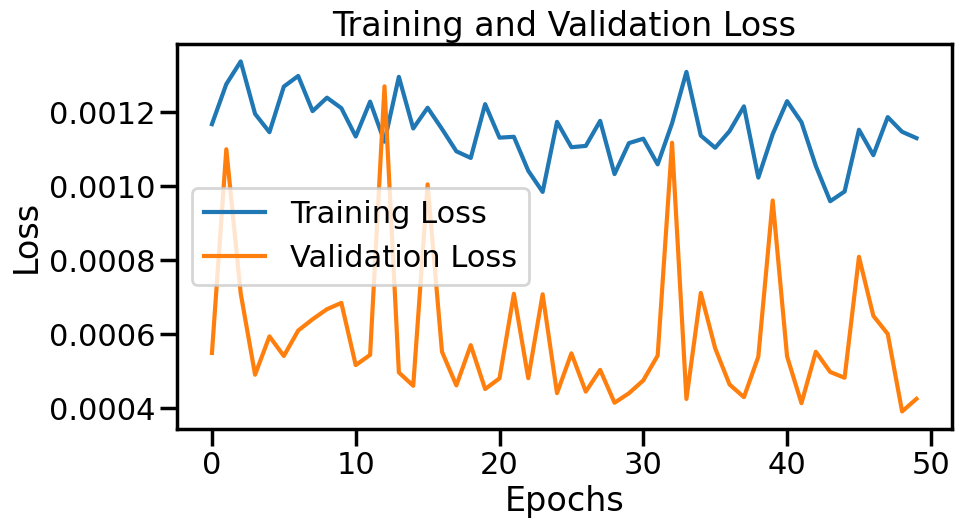

In [36]:
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Assuming train_losses and val_losses are lists that store the loss values for each epoch
train_losses = []
val_losses = []

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch.unsqueeze(1))
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                y_pred = model(X_batch)
                loss = criterion(y_pred, y_batch.unsqueeze(1))
                val_loss += loss.item()

        train_losses.append(train_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

    return model

# Re-train the model to capture the loss values
trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device)

# Plot the training and validation loss
plot_loss(train_losses, val_losses)


